### Setup

In [1]:
import os, sys
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if path not in sys.path:
    sys.path.insert(0, path)

In [2]:
from models import dcn_mix_eq4 as DCN
from models import common as util
from models.common import np

import importlib
importlib.reload(DCN)
importlib.reload(util)

<module 'models.common' from '/home/castro/projects/learning-projects/machine_learning/dc_network/models/common.py'>

In [3]:
from autograd import grad
from autograd.misc.flatten import flatten

In [4]:
np.random.seed(123)
cfg = {
    'lr': 1e-3,
    'batch_size': 32,
    'num_iters_reg': 20000,
    'num_iters_mov': 10000,
}

### Regression

In [5]:
input_len = 5
def f(x):
    return x[0] * x[1] + x[4]**2

def gen_sample(batch_size):
    x_dense = np.random.randn(batch_size, input_len)
    x_cat = np.zeros((0,))
    y = f(x_dense.T)
    return x_dense, x_cat, y.reshape(-1, 1)

params = DCN.init_params(n_dense_features=input_len, l_ff=0)
params, unflatten = flatten(params)

In [6]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, x_cat, target = gen_sample(batch_size=cfg['batch_size'])
    return util.mse(params, unflatten(params), DCN.predict, x_dense, x_cat, target)
    
def callback(params, iter, gradient):
    if iter % 500 == 0:
        loss = objective(params, iter)
        print(f"Step: {iter:<5} | MSE: {loss:.6f}")

nw_params1 = adam(grad(objective), params, step_size=cfg['lr'], num_iters=cfg['num_iters_reg'], callback=callback)

callback(nw_params1, cfg['num_iters_reg'], None)

Step: 0     | MSE: 5.468608
Step: 500   | MSE: 2.431649
Step: 1000  | MSE: 1.077651
Step: 1500  | MSE: 0.597243
Step: 2000  | MSE: 0.408687
Step: 2500  | MSE: 0.184258
Step: 3000  | MSE: 0.298851
Step: 3500  | MSE: 0.177054
Step: 4000  | MSE: 0.098358
Step: 4500  | MSE: 0.086199
Step: 5000  | MSE: 0.095257
Step: 5500  | MSE: 0.151729
Step: 6000  | MSE: 0.168599
Step: 6500  | MSE: 0.087357
Step: 7000  | MSE: 0.064383
Step: 7500  | MSE: 0.022048
Step: 8000  | MSE: 0.025272
Step: 8500  | MSE: 0.029298
Step: 9000  | MSE: 0.031169
Step: 9500  | MSE: 0.027371
Step: 10000 | MSE: 0.020945
Step: 10500 | MSE: 0.032552
Step: 11000 | MSE: 0.013846
Step: 11500 | MSE: 0.012080
Step: 12000 | MSE: 0.012317
Step: 12500 | MSE: 0.016026
Step: 13000 | MSE: 0.008230
Step: 13500 | MSE: 0.008003
Step: 14000 | MSE: 0.008871
Step: 14500 | MSE: 0.007450
Step: 15000 | MSE: 0.035188
Step: 15500 | MSE: 0.006847
Step: 16000 | MSE: 0.005450
Step: 16500 | MSE: 0.004536
Step: 17000 | MSE: 0.005172
Step: 17500 | MSE: 0

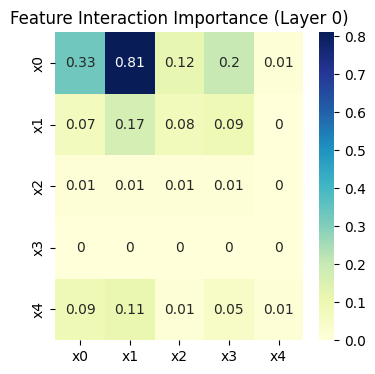

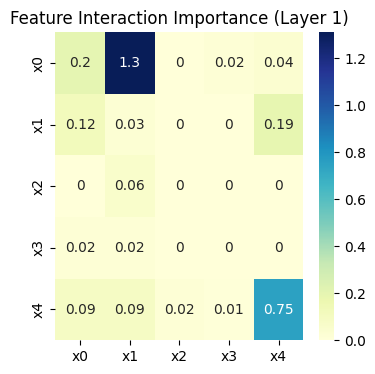

[[0.14036943]] [[0.82318405]] [0.85]


In [10]:
DCN.plot_heatmap(unflatten(nw_params1), 0)
DCN.plot_heatmap(unflatten(nw_params1), 1)
# x[0] * x[1] + x[4] ** 2
test_x = np.array([[0.2,0.2,0,0,0.9]])
print(DCN.predict(unflatten(params), test_x, np.array([])), DCN.predict(unflatten(nw_params1), test_x, np.array([])), f(test_x.T))

### MovieLens

In [8]:
import pandas as pd

df_ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df_users = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

df = pd.merge(df_ratings, df_users, on='user_id')

# df = df.sample(frac=1).reset_index(drop=True) # shuffle

In [9]:
d_embeddings = []

df['age'] = df['age'] / 100.0

df['liked'] = (df['rating'] > 3.0).astype(int)

cat_cols = ['user_id', 'item_id', 'gender', 'occupation', 'zip_code']

for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

In [10]:
print(df)

       user_id  item_id  rating  timestamp   age  gender  occupation  \
0          195      241       3  881250949  0.49       1          20   
1          185      301       3  891717742  0.39       0           6   
2           21      376       1  878887116  0.25       1          20   
3          243       50       2  880606923  0.28       1          19   
4          165      345       1  886397596  0.47       1           3   
...        ...      ...     ...        ...   ...     ...         ...   
99995      879      475       3  880175444  0.13       1          18   
99996      715      203       5  879795543  0.36       0           0   
99997      275     1089       1  874795795  0.21       1          18   
99998       12      224       2  882399156  0.47       1           3   
99999       11      202       3  879959583  0.28       0          13   

       zip_code  liked  
0           415      0  
1             0      0  
2           311      0  
3           591      0  
4         

In [11]:
cat_cols = ['user_id', 'item_id', 'gender', 'occupation', 'zip_code']
dense_cols = ['age']
n_dense_features = len(dense_cols)

d_embeddings = []
for col in cat_cols:
    vocab_size = df[col].nunique()
    emb_size = int((vocab_size ** (1.0/4.0)) * 6)
    d_embeddings.append((vocab_size, emb_size))
    
print(f"Cat Cols: {cat_cols + ['age_bucket']}")
print(f"Embedding Sizes: {d_embeddings}")

Cat Cols: ['user_id', 'item_id', 'gender', 'occupation', 'zip_code', 'age_bucket']
Embedding Sizes: [(943, 33), (1682, 38), (2, 7), (21, 12), (795, 31)]


In [12]:
def gen_sample(batch_size = 1):
    idx = np.random.randint(0, len(df), size = (batch_size))
    batch = df.iloc[idx]
    x_cat = np.array(batch[cat_cols].values)
    x_dense = np.array(batch[dense_cols].values)
    y = np.array(batch['liked'].values).reshape(-1, 1)
    return x_dense, x_cat, y

input_len = n_dense_features + sum(emb_size for _, emb_size in d_embeddings)

params = DCN.init_params(n_dense_features=n_dense_features, d_embeddings=d_embeddings)
params, unflatten = flatten(params)

In [13]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, x_cat, target = gen_sample(batch_size=cfg['batch_size'])
    return util.logloss(params, unflatten(params), DCN.predict, x_dense, x_cat, target)
    
def callback(params, iter, gradient):
    if iter % 500 == 0:
        dict_params = unflatten(params)
        x_dense, x_cat, target = gen_sample(batch_size=1000)
        pred = util.sigmoid(DCN.predict(dict_params, x_dense, x_cat))

        loss = util.logloss(params, dict_params, DCN.predict, x_dense, x_cat, target)
        scores = util.all_scores(pred, target)
        
        print(f"Step: {iter:<5} | LogLoss: {loss:.6f} | AUC: {scores['auc']:.6f} | Gini: {scores['gini']:.6f} | KS: {scores['ks']:.6f} | KS_threshold: {scores['ks_threshold']:.6f}")

nw_params3 = adam(grad(objective), params, step_size=cfg['lr'], num_iters=cfg['num_iters_mov'], callback=callback)

callback(nw_params3, cfg['num_iters_mov'], None)

Step: 0     | LogLoss: 0.822475 | AUC: 0.505132 | Gini: 0.010264 | KS: 0.049369 | KS_threshold: 0.609661
Step: 500   | LogLoss: 0.675159 | AUC: 0.741527 | Gini: 0.483054 | KS: 0.384847 | KS_threshold: 0.472905
Step: 1000  | LogLoss: 0.630025 | AUC: 0.771712 | Gini: 0.543425 | KS: 0.416055 | KS_threshold: 0.560155
Step: 1500  | LogLoss: 0.586288 | AUC: 0.803076 | Gini: 0.606152 | KS: 0.468390 | KS_threshold: 0.583432
Step: 2000  | LogLoss: 0.573785 | AUC: 0.803212 | Gini: 0.606424 | KS: 0.467542 | KS_threshold: 0.529080
Step: 2500  | LogLoss: 0.595885 | AUC: 0.782919 | Gini: 0.565838 | KS: 0.454270 | KS_threshold: 0.486991
Step: 3000  | LogLoss: 0.556397 | AUC: 0.809307 | Gini: 0.618614 | KS: 0.477022 | KS_threshold: 0.570437
Step: 3500  | LogLoss: 0.540575 | AUC: 0.825432 | Gini: 0.650863 | KS: 0.497803 | KS_threshold: 0.528493
Step: 4000  | LogLoss: 0.584262 | AUC: 0.774152 | Gini: 0.548304 | KS: 0.409444 | KS_threshold: 0.539526
Step: 4500  | LogLoss: 0.555436 | AUC: 0.805565 | Gini:

In [14]:
# DCN.plot_heatmap(unflatten(nw_params3), 0)